In [1]:
import jax
import jaxopt
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
import matplotlib.pyplot as plt
%matplotlib inline
# import pandas as pd
from time import process_time

from src.linear_solvers_scan import forward_solve_SD, forward_solve_jacobi
from src.BTCS_Stepper import BTCS_Stepper, RandomTruncatedFourierSeries, rollout, dataloader
from src.prdp import should_refine

# add magic comments for autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
jax.devices()

In [ ]:
N_DOF = 30   # (along each dimension)
MLP_WIDTH = 3000
grid_1d = jnp.linspace(0, 1, N_DOF+2)[1:-1]

## Heat equation

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u
$$

where $u$ is the temperature, $\alpha$ is the thermal diffusivity, and $\nabla^2$ is the Laplacian operator.

## 1D

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

#### Discretization

$$
\frac{u_i^{n} - u_i^{n-1}}{\Delta t} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}
$$

Then
$$
u_i^{n} - \frac{\alpha \Delta t}{\Delta x^2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right) = u_i^{n-1}
$$

## 2D

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

#### Discretization: BTCS

$$
\frac{u_{i,j}^{n} - u_{i,j}^{n-1}}{\Delta t} = \alpha \left( \frac{u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n}}{\Delta x^2} + \frac{u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n}}{\Delta y^2} \right)
$$

Using $\Delta y = \Delta x$

$$
u_{i,j}^{n} - \frac{\alpha \Delta t}{\Delta x^2} \left( u_{i+1,j}^{n} + u_{i-1,j}^{n} + u_{i,j+1}^{n} + u_{i,j-1}^{n} - 4u_{i,j}^{n} \right) = u_{i,j}^{n-1}
$$


$$
u_0(x,y) = sin(2 \pi x) sin(2 \pi y)
$$

In [ ]:
# create sinusoidal initial condition on a 2D grid
grid_2d = jnp.meshgrid(grid_1d, grid_1d, indexing='ij')
u_0_2d = jnp.sin(2 * jnp.pi * grid_2d[0]) * jnp.sin(2 * jnp.pi * grid_2d[1])
plt.figure(); plt.title('Initial condition')
plt.imshow(u_0_2d, origin='lower')
plt.colorbar()

In [5]:
btcs_stepper = BTCS_Stepper(num_points=N_DOF, dim=2)
u_0 = jnp.reshape(u_0_2d, -1) # flattening the 2D initial condition
assert u_0.shape == (N_DOF**2,)

In [6]:
# test the forward solve - direct and solver
N_STEPS = 50
trj_direct = rollout(btcs_stepper, N_STEPS, include_init=True)(u_0)
trj_solver = rollout(btcs_stepper.jacobi_dynamic, N_STEPS, include_init=True, solver_iterations=20)(u_0)
assert trj_direct.shape == trj_solver.shape == (N_STEPS+1, N_DOF**2)

rel_error = jnp.abs(trj_direct - trj_solver) / jnp.abs(trj_direct)

In [7]:
# plot the time steps as 2D animations
trj_direct_2d = jnp.reshape(trj_direct, (N_STEPS+1, N_DOF, N_DOF))
trj_solver_2d = jnp.reshape(trj_solver, (N_STEPS+1, N_DOF, N_DOF))
rel_error_2d = jnp.reshape(rel_error, (N_STEPS+1, N_DOF, N_DOF))

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Direct')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Linear Solver')
txt_title = fig.suptitle('Time Step: 0')

# create an animation
im1 = ax1.imshow(trj_direct_2d[0], origin='lower', animated=True)
im2 = ax2.imshow(trj_solver_2d[0], origin='lower', animated=True)
plt.close()

def animate(i):
    im1.set_array(trj_direct_2d[i])
    im2.set_array(trj_solver_2d[i])
    txt_title.set_text(f'Time Step: {i}')
    return (im1, im2)

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, frames=N_STEPS+1, interval=100, blit=True)

# from IPython.display import HTML
# HTML(anim.to_html5_video())


# Define training and test data
Each $u^0$ is the sum of first `num_modes` sine and cosine modes of the domain with random amplitudes.

### 1D

$$
u_0(x) = \sum_n ( a_n \sin(2n \pi x) + b_n \cos(2n \pi x) )
$$

### 2D

$$
u_0(x,y) = \sum_n ( a_n \sin(2n \pi x) \sin(2n \pi y) + b_n \cos(2n \pi x) \cos(2n \pi y) + c_n \sin(2n \pi x) \cos(2n \pi y) + d_n \cos(2n \pi x) \sin(2n \pi y) )
$$

where $a_n$, $b_n$, ... are sampled from $U(-1,1)$

### Create training set and dataloader

In [8]:
ic_generator = RandomTruncatedFourierSeries(domain_extent=1.0, num_modes=5, dim=2) 

In [9]:
NUM_TRAINING_SAMPLES = 200

# Training Data: X's
seed = 1337
ic_master_key = jax.random.PRNGKey(seed)
ic_keys = jax.random.split(ic_master_key, NUM_TRAINING_SAMPLES)
ic_funs = jax.vmap(ic_generator)(ic_keys) # list of functions that generate initial conditions on given grid
ic_set_2d = jax.vmap(lambda f: f(grid_2d))(ic_funs) # vmap the list of functions to generate many initial conditions

assert ic_set_2d.shape == (NUM_TRAINING_SAMPLES, N_DOF, N_DOF)

In [ ]:
# 1D: Plot a subset of the intial conditions
# plt.plot(grid, ic_set[5:10].T);

# 2D: Plot an initial condition
fig,axs = plt.subplots(1,5)
# set figure size
fig.set_figwidth(15); fig.set_figheight(3)
fig.suptitle('Some Initial Conditions from the training set')
axs_index = 0
for i in jax.random.randint(ic_master_key, shape=(5,), minval=0, maxval=NUM_TRAINING_SAMPLES):
    axs[axs_index].imshow(ic_set_2d[i], origin='lower')
    axs[axs_index].axis('off')
    axs[axs_index].set_title(f'IC {i}')
    axs_index += 1

In [11]:
# flatten ic_set
ic_set = jnp.reshape(ic_set_2d, (NUM_TRAINING_SAMPLES, N_DOF**2))
# Training Data: Y's
data_trjs_direct = jax.vmap(rollout(btcs_stepper, 2, include_init=True))(ic_set)

### Generate validation set

In [12]:
N_TEST_SAMPLES = 5
# Validation Data: X's
test_ic_master_key = jax.random.PRNGKey(seed + 1)
test_ic_keys = jax.random.split(test_ic_master_key, N_TEST_SAMPLES)
test_ic_funs = jax.vmap(ic_generator)(test_ic_keys)
test_ic_set_2d = jax.vmap(lambda f: f(grid_2d))(test_ic_funs)

assert test_ic_set_2d.shape == (N_TEST_SAMPLES, N_DOF, N_DOF)

val_ic_set = jnp.reshape(test_ic_set_2d, (N_TEST_SAMPLES, N_DOF**2))
# Validation Data: Y's
val_data_trjs = jax.vmap(rollout(btcs_stepper, 2, include_init=True))(val_ic_set)

In [ ]:
val_data_trjs.shape

In [14]:
@eqx.filter_jit
def val_loss(m, val_data):
    """Compute the loss on the test set.

    Args:
        m: the model to evaluate
        val_data: the test data, with shape (n_samples, n_steps, n_dof)
    """
    print("compiling val_loss()")
    val_ic_set = val_data[:,0]
    pred_trajectories = jax.vmap(rollout(m, 2, include_init=True))(val_ic_set)
    pred_1_errors = jnp.linalg.norm(pred_trajectories[:, 1] - val_data[:, 1], axis=1) # normed over n_dof
    pred_2_errors = jnp.linalg.norm(pred_trajectories[:, 2] - val_data[:, 2], axis=1) # normed over n_dof
    
    data_1_norms  = jnp.linalg.norm(val_data[:, 0], axis=1) # norm over n_dof
    data_2_norms = jnp.linalg.norm(val_data[:, 1], axis=1) # norm over n_dof
    
    pred_1_mse_normalized = jnp.mean((pred_1_errors**2 / data_1_norms**2), axis=0) # mean squared for over all samples
    pred_2_mse_normalized = jnp.mean((pred_2_errors**2 / data_2_norms**2), axis=0) # mean squared for over all samples
    
    return jnp.hstack((pred_1_mse_normalized, pred_2_mse_normalized))

In [15]:
import jax.tree_util as jtu
def count_parameters(model: eqx.Module):
    return sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

## Residuum plot

In [ ]:
SOLVER_NAME = 'jacobi'
def relative_residuum_hist(state, n_inner):
    res_2 = btcs_stepper.residuum_history(state, SOLVER_NAME, n_inner) # (n_iter+1, n_dof)
    rel_residuum_hist = jnp.linalg.norm(res_2, axis=1) / jnp.linalg.norm(state)
    return rel_residuum_hist # (n_iter+1,)

pred_1_set = data_trjs_direct[:, 1]
res_hist_all = jax.vmap(relative_residuum_hist, in_axes=(0, None))(pred_1_set, 80) # shape: (n_samples, n_iter+1)
res_hist_mean = jnp.mean(res_hist_all, axis=0)
res_hist_std = jnp.std(res_hist_all, axis=0)

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(res_hist_mean, label="primal residuum")
ax.fill_between(range(res_hist_mean.shape[0]), res_hist_mean - res_hist_std, res_hist_mean + res_hist_std, alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel("# iterations")
ax.set_title(f"Heat 2D, Residuums, solver={SOLVER_NAME}")

ax.grid(which='major', axis='y')
ax.minorticks_on()
ax.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
ax.grid(which='major', axis='both', linestyle='-', linewidth=1.0)

# fig.savefig(f"figures/heat_2d__residuum__{SOLVER_NAME}.pdf", bbox_inches="tight")

# Mix-Chain differentiable physics training
One network followed by one iterative solver step



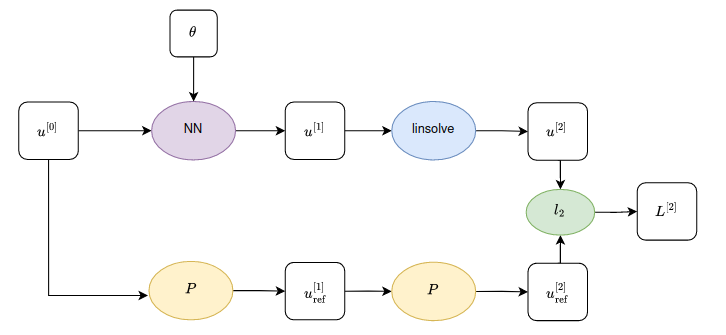

In [17]:
learning_rate = optax.exponential_decay(1e-3, 100, 0.9)
optimizer = optax.adam(learning_rate)

### Constant solver iterations

In [ ]:
def loss_fn(model, data):
    ic = data[:, 0]
    # Notice the difference, that the target is now two steps into the future
    target = data[:, 2]

    prediction_1 = jax.vmap(model)(ic)

    # Here, you would then have your differentiable BTCS solver
    prediction_2 = jax.vmap(btcs_stepper.jacobi, in_axes=(0, 0, None))(prediction_1, jnp.zeros_like(prediction_1), 20)

    return jnp.mean((prediction_2 - target)**2)

@eqx.filter_jit
def update_fn(model, state, data):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, data)
    updates, new_state = optimizer.update(grad, state, model)
    new_model= eqx.apply_updates(model, updates)
    return new_model, new_state, loss

model_MLP = eqx.nn.MLP(in_size=N_DOF**2, out_size=N_DOF**2, width_size=MLP_WIDTH, depth=3, activation=jax.nn.relu, key=jax.random.PRNGKey(92))
print(f"number of model parameters = {count_parameters(model_MLP)}")

opt_state = optimizer.init(eqx.filter(model_MLP, eqx.is_array))

N_EPOCHS = 100
BATCH_SIZE = 25
loss_history_solver = []
rel_error_history_solver = []

shuffle_key = jax.random.PRNGKey(42)
for epoch in range(N_EPOCHS):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    loss_mini_batch = []
    for batch in dataloader(data_trjs_direct, key=subkey, batch_size=BATCH_SIZE):
        model_MLP, opt_state, loss = update_fn(model_MLP, opt_state, batch)
        # loss_history_solver.append(loss)
        loss_mini_batch.append(loss)
    loss_history_solver.append(np.mean(loss_mini_batch))
    rel_error = val_loss(model_MLP, val_data_trjs)
    rel_error_history_solver.append(rel_error)

    print(f"Epoch {epoch+1}/{N_EPOCHS}, loss: {loss}")

In [ ]:
rel_error_history_solver = np.array(rel_error_history_solver)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(loss_history_solver)
ax[0].set_yscale('log'); ax[0].grid()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss (minibatch averaged)')

ax[1].plot(rel_error_history_solver[:, 0], label='1-step')
ax[1].plot(rel_error_history_solver[:, 1], label='2-step')
ax[1].set_yscale('log'); ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Relative MSE Error')
ax[1].legend()


In [ ]:
print(f"Mean relative error: {val_loss(model_MLP, val_ic_set, val_data_trjs)}")

### Different constant N values

In [20]:
def loss_fn(model, data, inner_iterations):
    print("compiling loss_fn")
    ic = data[:, 0]
    target = data[:, 2]
    prediction_1 = jax.vmap(model)(ic) # batched forward pass # (batch_size, N_DOF)
    prediction_2 = jax.vmap(btcs_stepper.jacobi_dynamic, in_axes=(0, None))(prediction_1, inner_iterations)
    return jnp.mean((prediction_2 - target)**2) # MSE over batches as well as space

@eqx.filter_jit
def update_fn(model, state, data, inner_iterations):
    print("compiling update_fn")
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, data, inner_iterations)
    updates, new_state = optimizer.update(grad, state, model)
    new_model= eqx.apply_updates(model, updates)
    return new_model, new_state, loss

In [ ]:
# SEED_LIST = [1, 2, 25, 50, 1000, 1337, 2668, 3999, 12345, 54321]
SEED_LIST = [1]
N_INNER_LIST = [1,2,3,4,5,6,7,8,9,10,12,15,20,40,60]
SAVE_RESULTS = False

N_EPOCHS = 70
BATCH_SIZE = 25

for seed_count, seed in enumerate(SEED_LIST):
    
    print(f"Training with seed {seed} ({seed_count+1} of {len(SEED_LIST)})")
    key = jax.random.PRNGKey(seed)
    key, model_init_key = jax.random.split(key)
    
    losses_all_n = []
    errors_all_n = []

    # Loop over n_inner
    for n_inner in N_INNER_LIST:
        print(f"\nTraining with {n_inner} inner iterations\n")
        
        # initialize model
        model_MLP = eqx.nn.MLP(
            in_size=N_DOF**2, out_size=N_DOF**2, 
            width_size=MLP_WIDTH, depth=3, 
            activation=jax.nn.relu, 
            key=model_init_key,
        )
        
        # initialize optimizer
        opt_state = optimizer.init(eqx.filter(model_MLP, eqx.is_array))

        # init metrics
        loss_history = [loss_fn(model_MLP, data_trjs_direct, n_inner)]
        error_history = [val_loss(model_MLP, val_data_trjs)]

        # training loop
        key, shuffle_key = jax.random.split(key)
        for epoch in range(N_EPOCHS):
            shuffle_key, subkey = jax.random.split(shuffle_key)
            loss_mini_batch = []
            for batch in dataloader(data_trjs_direct, key=subkey, batch_size=BATCH_SIZE):
                model_MLP, opt_state, loss = update_fn(model_MLP, opt_state, batch, n_inner)
                loss_mini_batch.append(loss)
            
            loss_history.append(np.mean(loss_mini_batch))
            error_history.append(val_loss(model_MLP, val_data_trjs))
            print(f"Epoch {epoch+1}/{N_EPOCHS}, loss: {loss_history[-1]}, rel error: {error_history[-1]}")
        
        losses_all_n.append(loss_history)
        errors_all_n.append(np.array(error_history))
    
    # save results
    losses_all_n = np.array(losses_all_n)
    errors_all_n = np.array(errors_all_n) # shape (len(N_INNER_LIST), N_EPOCHS, 2)
    if SAVE_RESULTS:
        df = pd.DataFrame({
            "max_iter": N_INNER_LIST,
            "losses": list(losses_all_n),
            "1-step errors": list(errors_all_n[:,:,0]),
            "2-step errors": list(errors_all_n[:,:,1]),
            "seed": seed,
        })
        file_name = f"results/heat_2d_sep17_jacobi_unrolled/maxiter_constant__seed_{seed}.pkl"
        df.to_pickle(file_name)

In [ ]:
# plot results of last seed

errors_all_n = np.array(errors_all_n) # shape (len(N_INNER_LIST), N_EPOCHS, 2)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, n_inner in enumerate(N_INNER_LIST):
    axs[0].plot(losses_all_n[i], label=f"{N_INNER_LIST[i]}")
    axs[1].plot(errors_all_n[i,:,0], label=f"{N_INNER_LIST[i]}")
    axs[2].plot(errors_all_n[i,:,1], label=f"{N_INNER_LIST[i]}")

axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss (minibatch avg.)'); 
axs[0].set_yscale('log'); axs[0].grid(); axs[0].set_ylim(1e-5, 1)

axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('1 Step nMSE');
axs[2].set_xlabel('Epoch'); axs[2].set_ylabel('2-Step nMSE');
axs[1].set_yscale('log'); axs[2].set_yscale('log');
axs[1].grid(); axs[2].grid()
axs[1].set_ylim(1e-3, 10); axs[2].set_ylim(1e-3, 10)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### PRDP

In [17]:
N_MIN, N_STEP = 1,1

In [ ]:
SAVE_RESULTS = False
SEED_LIST = [1, 2, 25, 50, 1000, 1337, 2668, 3999, 12345, 54321]
SEED_LIST = [1]
N_EPOCHS = 70
BATCH_SIZE = 25

for seed_count, seed in enumerate(SEED_LIST):
    print(f"Training with seed {seed} ({seed_count+1}/{len(SEED_LIST)})")
    key = jax.random.PRNGKey(seed)
    
    # init model to be trained
    key, model_init_key = jax.random.split(key)    
    model_mlp_prdp = eqx.nn.MLP(
        in_size=N_DOF**2, out_size=N_DOF**2, 
        width_size=MLP_WIDTH, depth=3, 
        activation=jax.nn.relu, 
        key=model_init_key,
    )

    # init optimizer
    opt_state = optimizer.init(eqx.filter(model_mlp_prdp, eqx.is_array))
    
    # initialize metrics
    n_inner_tracker = N_MIN
    loss_hist_prdp = [loss_fn(model_mlp_prdp, data_trjs_direct, n_inner_tracker)]
    error_hist_prdp = [val_loss(model_mlp_prdp, val_data_trjs)]
    n_inner_hist_prdp = [np.nan] # no value at zeroth epoch, but need same list length as loss_hist
    
    # initialize PRDP's Nmax checkpoint error
    should_refine.error_checkpoint = error_hist_prdp[-1][1] #[last_error][which-step error]

    # training loop
    key, shuffle_key = jax.random.split(key)
    for epoch in range(N_EPOCHS):
        shuffle_key, subkey = jax.random.split(shuffle_key)
        loss_mini_batch = []
        for batch in dataloader(data_trjs_direct, key=subkey, batch_size=BATCH_SIZE):
            model_mlp_prdp, opt_state, loss = update_fn(model_mlp_prdp, opt_state, batch, 
                                                        n_inner_tracker)
            loss_mini_batch.append(loss)
        
        loss_hist_prdp.append(np.mean(loss_mini_batch))
        error_hist_prdp.append(val_loss(model_mlp_prdp, val_data_trjs))
        n_inner_hist_prdp.append(n_inner_tracker)
        print(f"Epoch {epoch+1}/{N_EPOCHS}, n_inner: {n_inner_tracker}, loss: {loss_hist_prdp[-1]}, error: {error_hist_prdp[-1]}")

        # PRDP
        if should_refine(np.array(error_hist_prdp)[:, 1],   # [all epochs, 2 step error]
                         0.9, 0.9, 6, 3): 
            n_inner_tracker += N_STEP
    
    # SAVE
    loss_hist_prdp = np.array(loss_hist_prdp)
    error_hist_prdp = np.array(error_hist_prdp)
    if SAVE_RESULTS:
        df = pd.DataFrame({
            "losses": [loss_hist_prdp],
            "1-step errors": [error_hist_prdp[:,0]],
            "2-step errors": [error_hist_prdp[:,1]],
            "n_inner": [n_inner_hist_prdp],
            "max_iter": "PRDP",
            "auto_using": "two-step-error",
            "seed": seed,
        })
        file_name = f"results/heat_2d_sep17_jacobi_unrolled/maxiter_auto__seed_{seed}.pkl"
        df.to_pickle(file_name)
    

In [ ]:
error_hist_prdp = np.array(error_hist_prdp)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
last = 70

for i, n_inner in enumerate(N_INNER_LIST):
    axs[0].plot(losses_all_n[i], label=f"{N_INNER_LIST[i]}")
    axs[1].plot(errors_all_n[i,:,0], label=f"{N_INNER_LIST[i]}")
    axs[2].plot(errors_all_n[i,:,1], label=f"{N_INNER_LIST[i]}")

axs[0].plot(loss_hist_prdp, label='PRDP', color='black')
axs[1].plot(error_hist_prdp[:last, 0], label='PRDP', color='black')
axs[2].plot(error_hist_prdp[:last, 1], label='PRDP', color='black')

axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss (minibatch avg.)');
axs[0].set_yscale('log'); axs[0].grid(); axs[0].set_ylim(1e-5, 1)

axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('1-step nMSE');
axs[2].set_xlabel('Epoch'); axs[2].set_ylabel('2-step nMSE');
axs[1].set_yscale('log'); axs[2].set_yscale('log');
axs[1].grid(); axs[2].grid()
axs[1].set_ylim(1e-3, 10); axs[2].set_ylim(1e-3, 10)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="n_inner")